# Plan
- step01(PASS) : deepseekocr로 table을 제외한 이미지 구역을 추출
- step02 : 이미지 구역에서 심볼을 기준으로 크롭하고 다음 단계로(sketch_detection_sysmbol_v1,v2)
- step03 :각 크롭한 이미지를 ocr로 텍스트 추출하기 : deepseekocr

### setting

In [1]:
import cv2, os
from symbol_region_splitter import match_symbol, split_and_extract_regions, split_regions_vertical
from utils import visualize_detections, show_image_highres,is_text_like_present

from transformers import AutoModel, AutoTokenizer
import torch
import pytesseract

### 테스트할 도면과 저장 위치 지정
image_file = '../data/hard_task_test01_v1.PNG'
output_path = './result'
symbol_path = '../data/symbol_mini.PNG'

# deepseekOCR 세팅
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
# _attn_implementation='flash_attention_2' : 나중에 파이프라인 통합시 설치 필요
model = model.eval().cuda().to(torch.bfloat16)

prompt = "<image>\nFree OCR. " # 무한 텍스트 추출 오류 이슈
# prompt = "<image>\nExtract all text from this image as plain text."


/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### step02-03

탐지된 심볼 수 (중복 제거 후): 6


/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


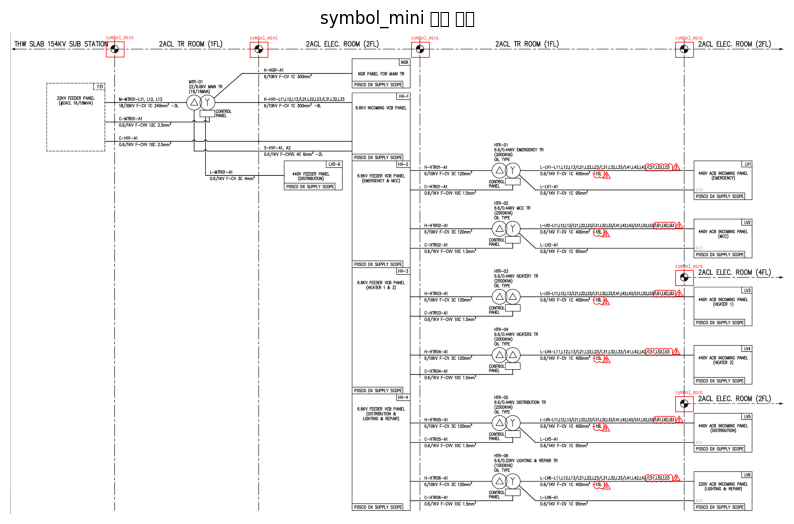

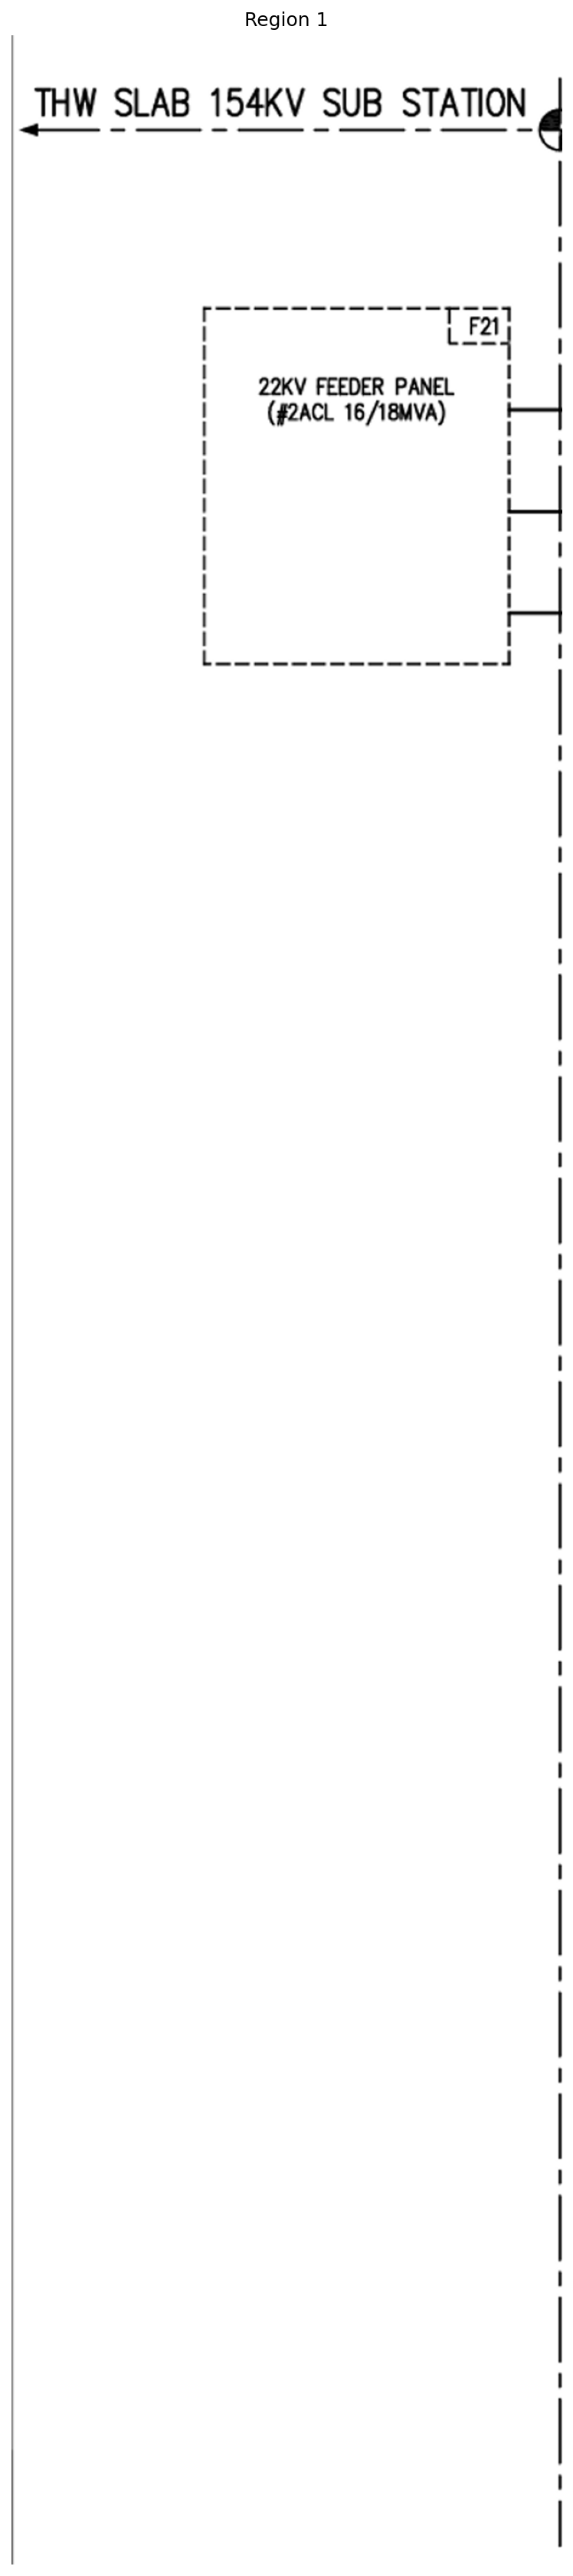

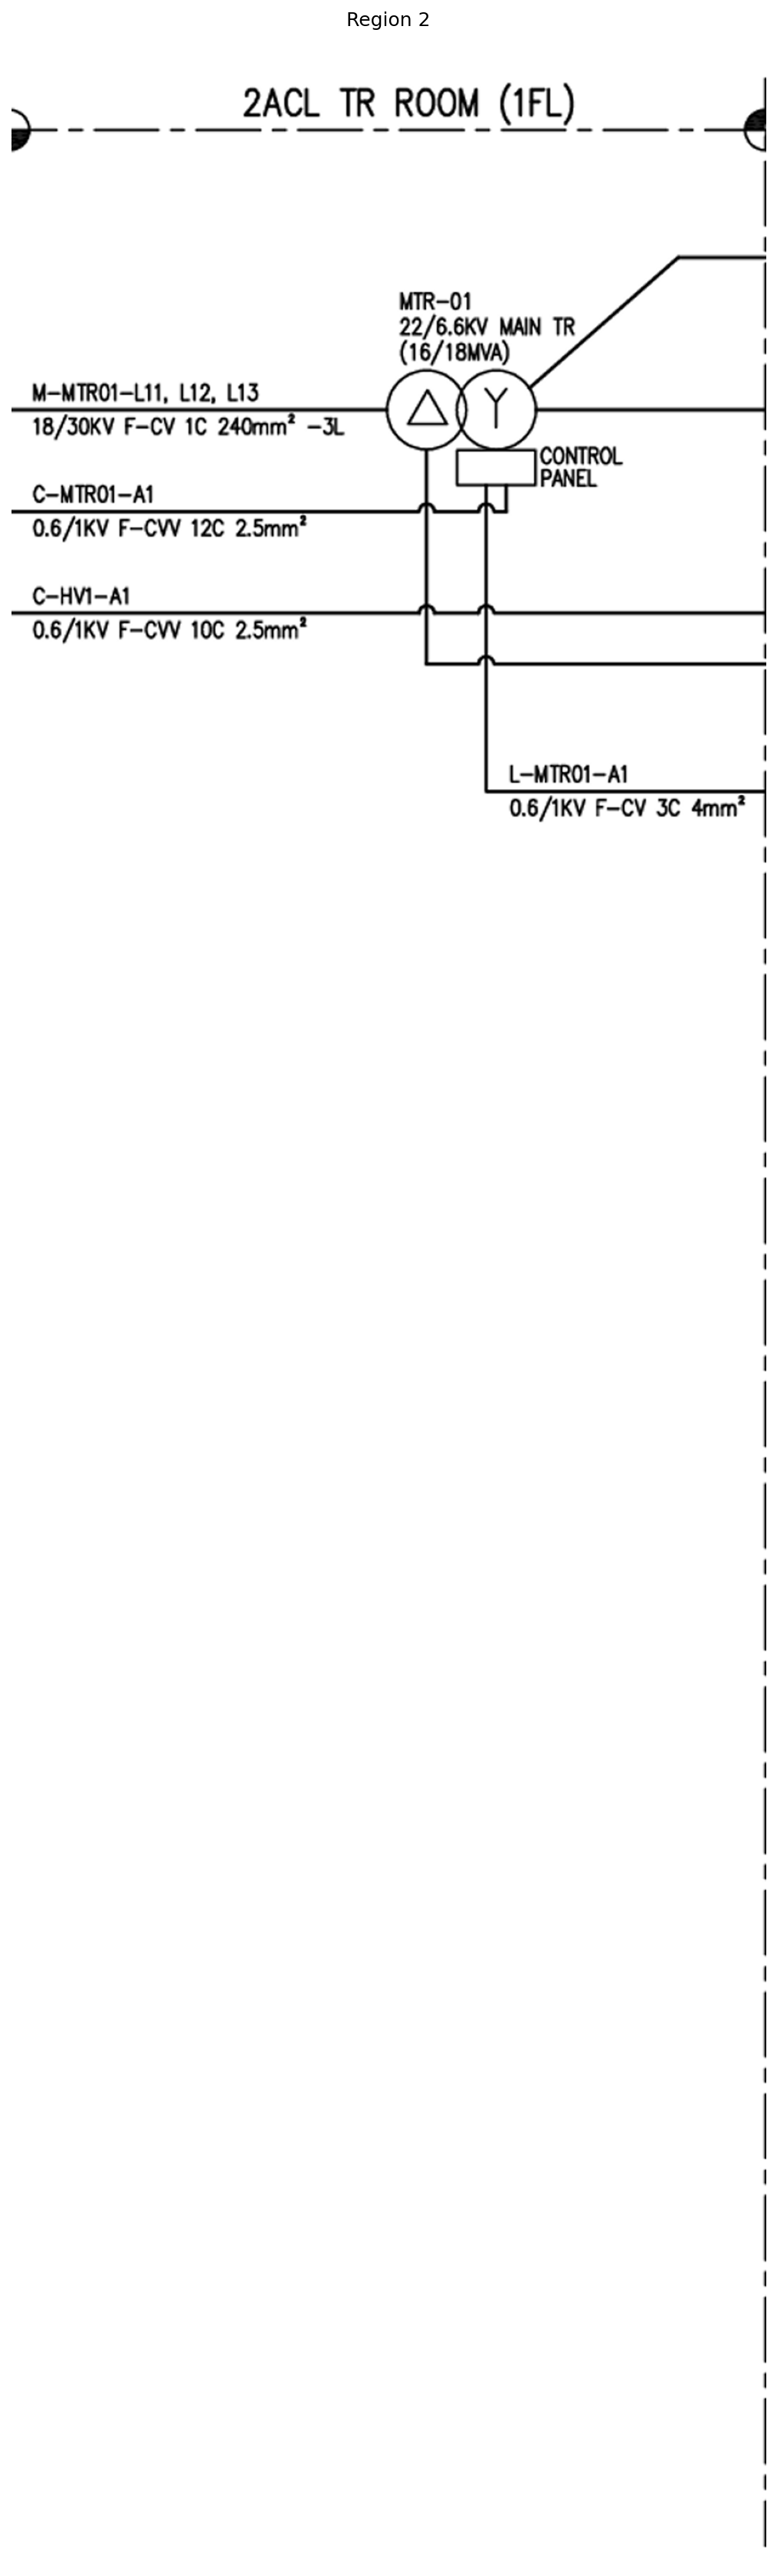

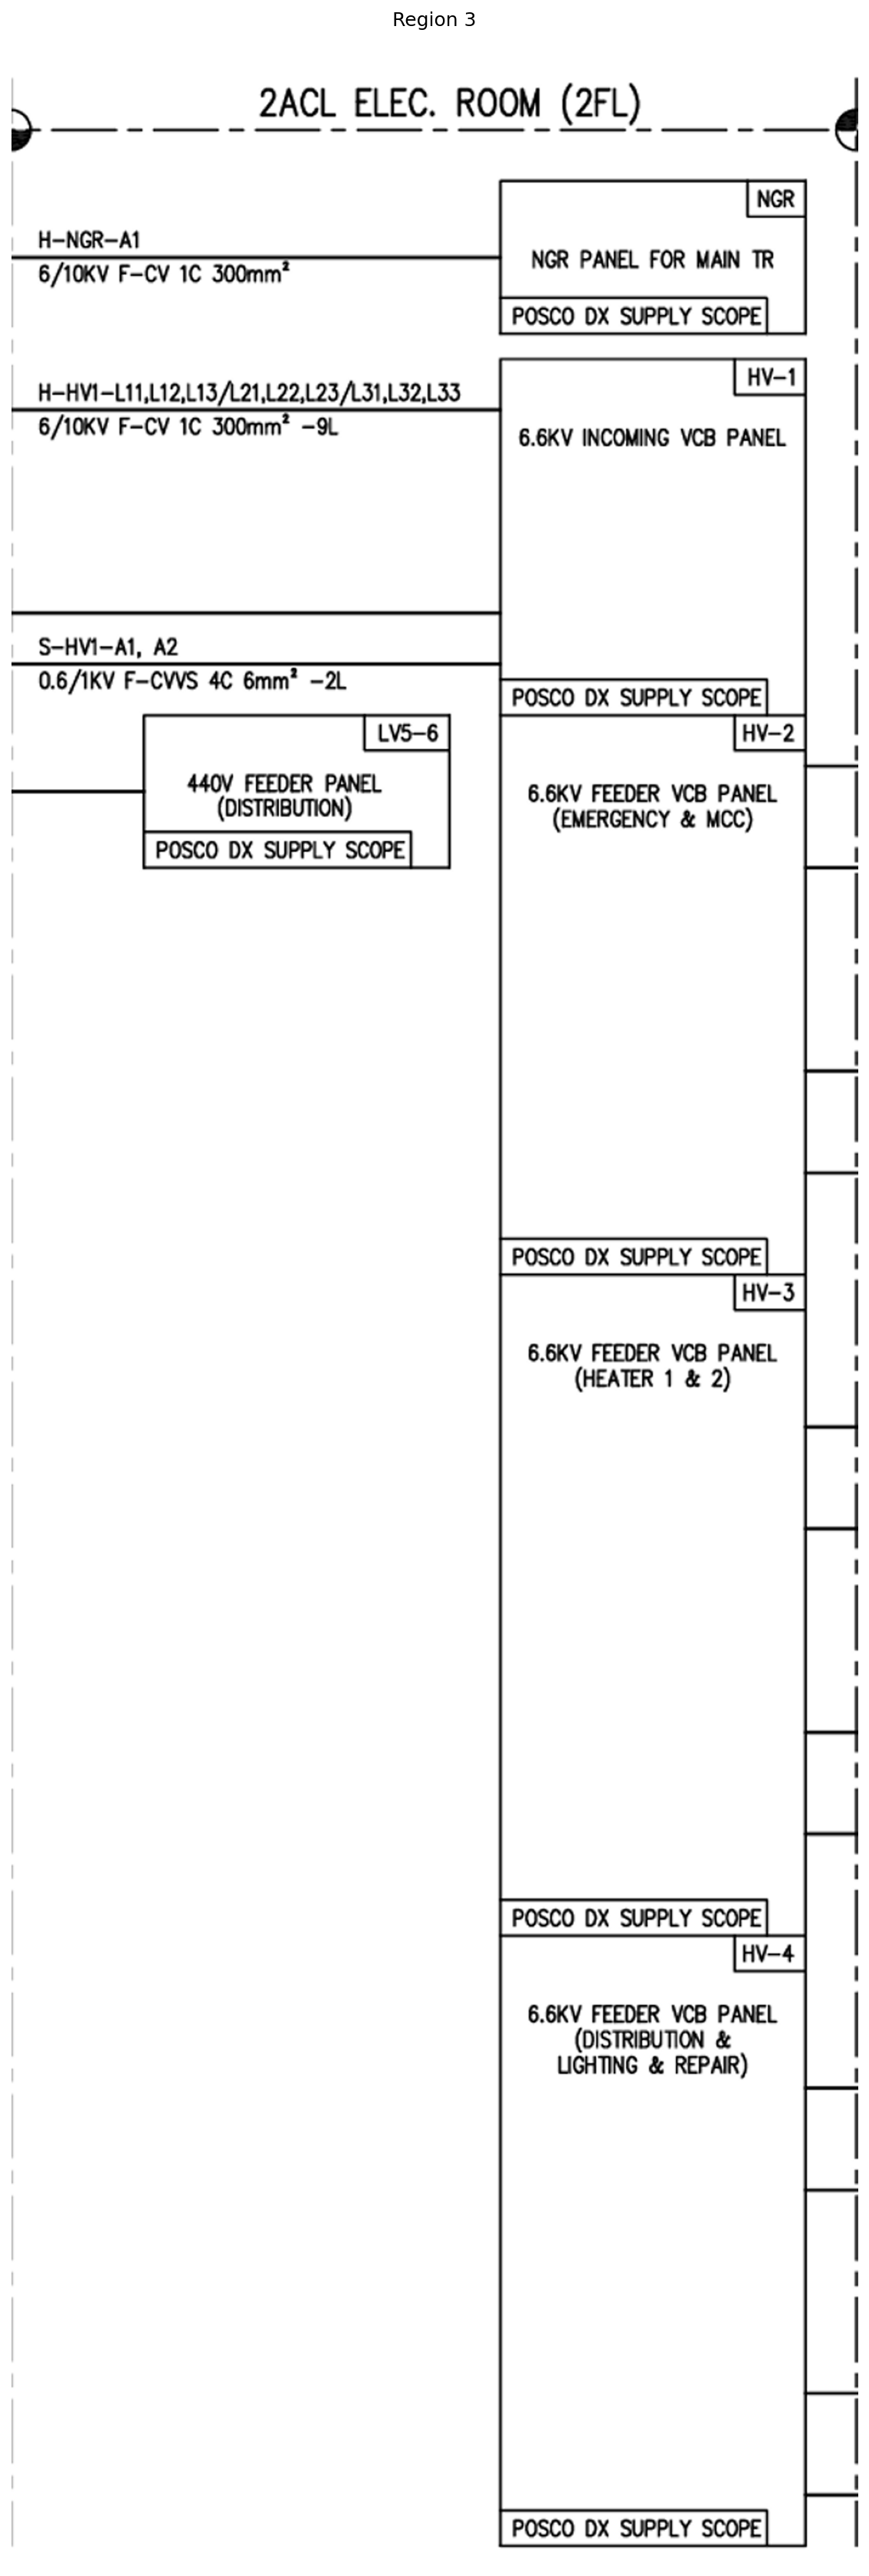

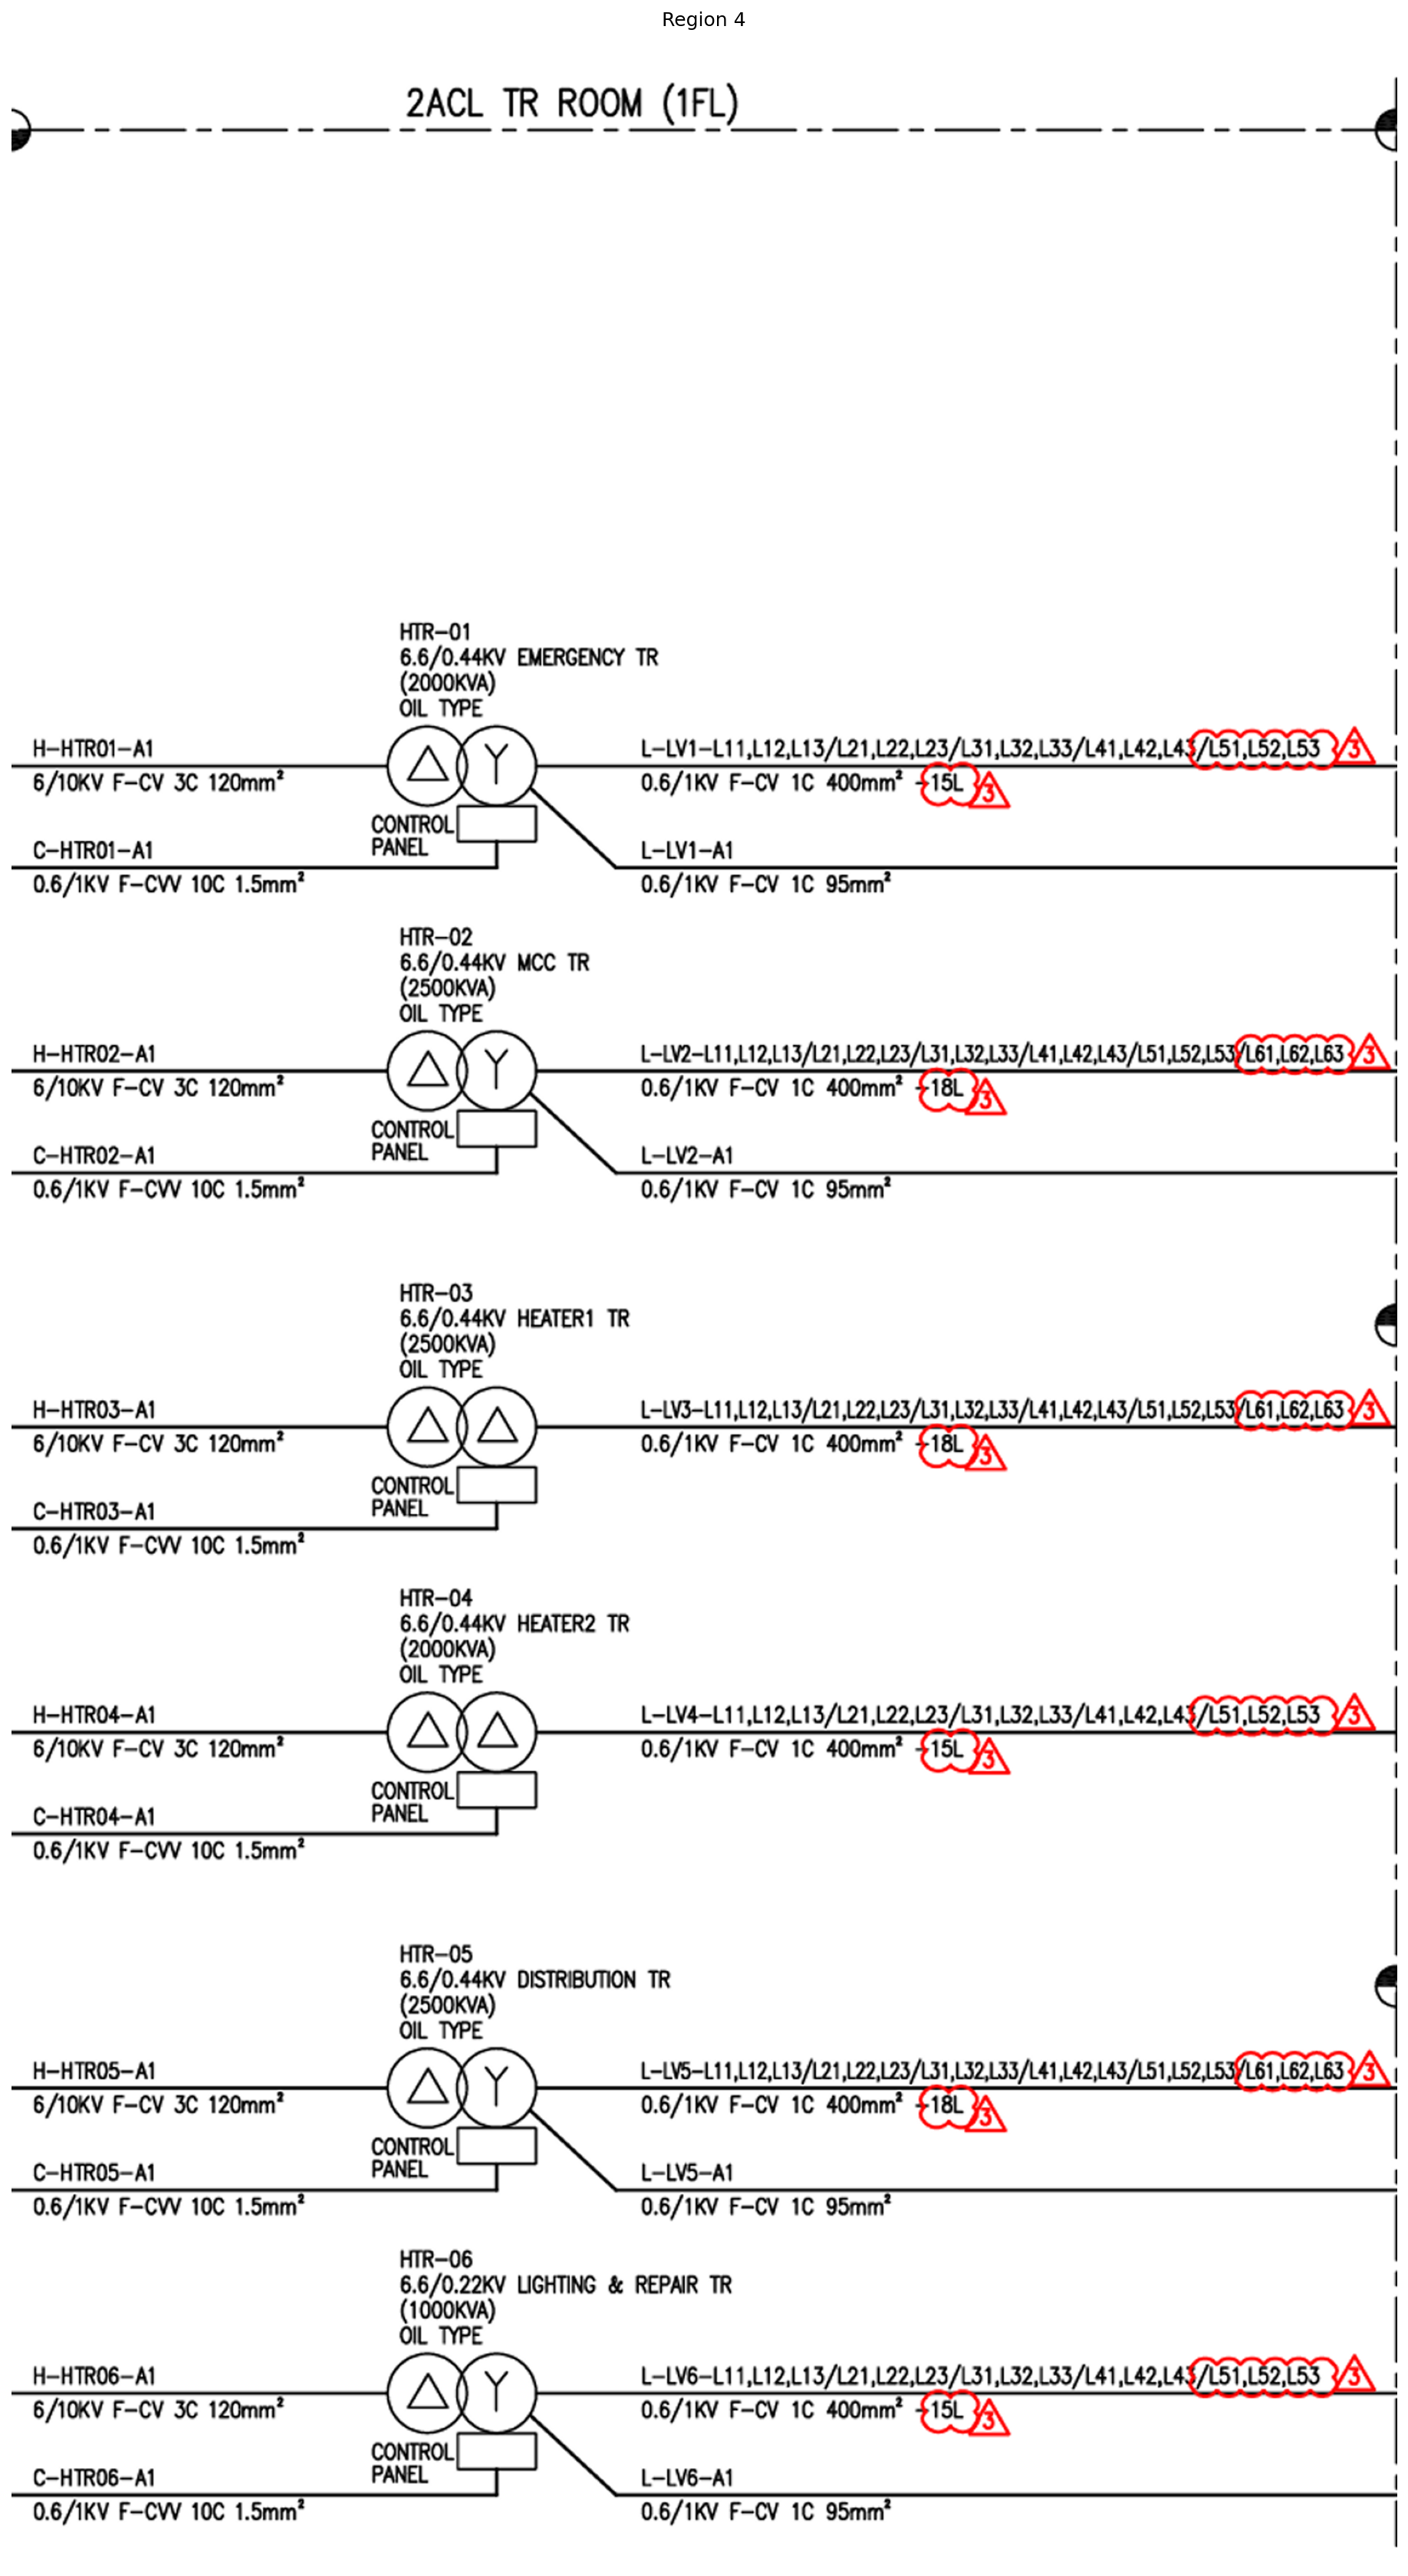

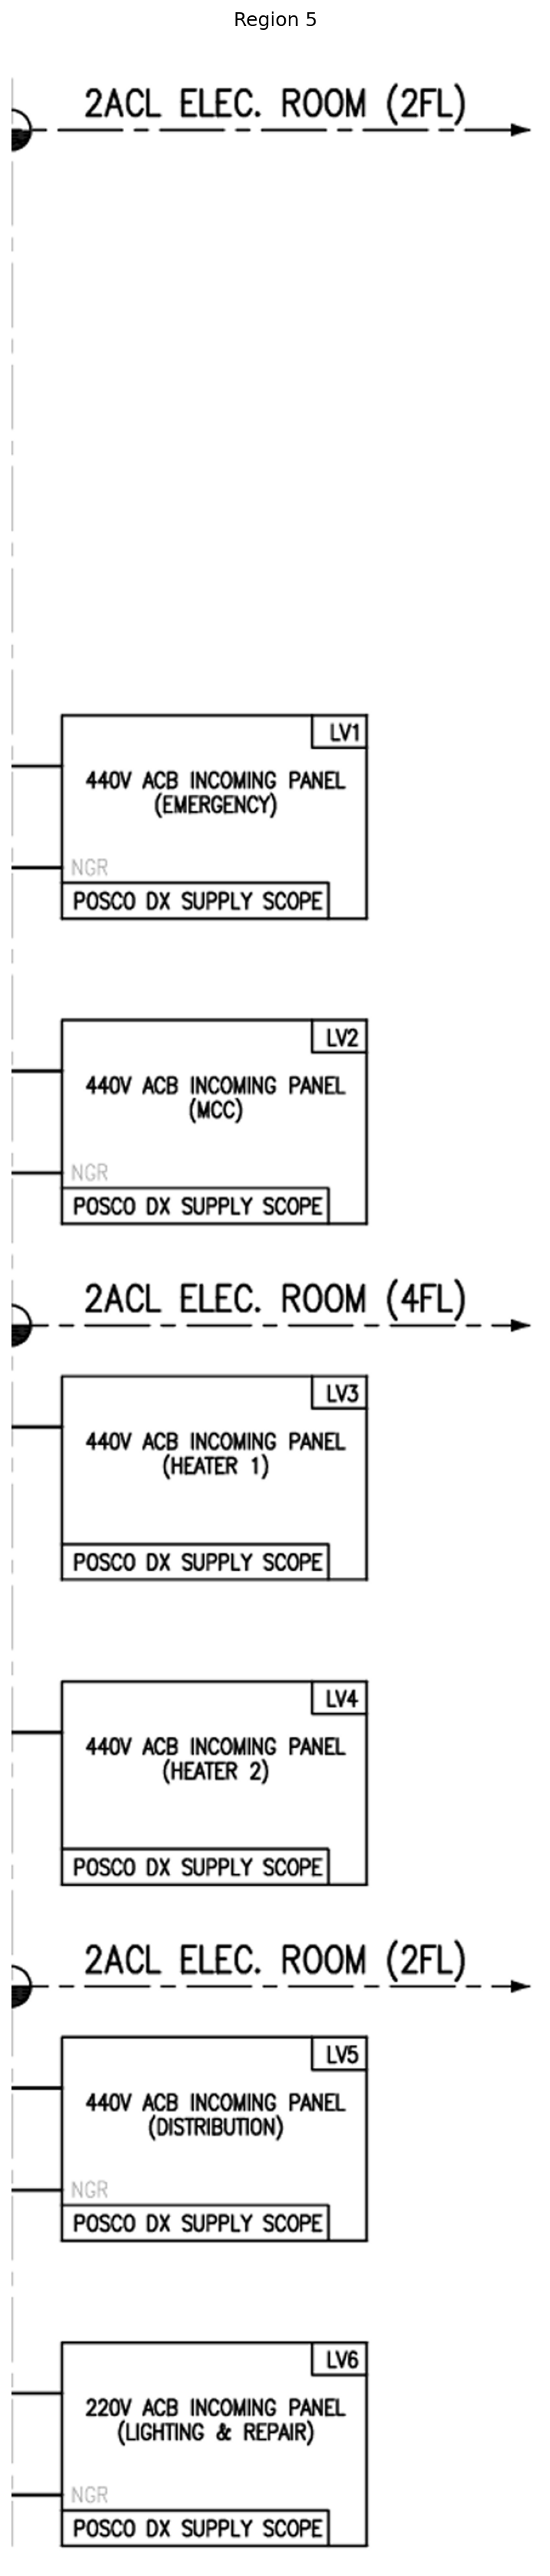

In [2]:
# 이미지 로드
drawing = cv2.imread(image_file)
if drawing is None:
    raise FileNotFoundError(f"도면을 찾을 수 없습니다: {image_file}")
drawing_gray = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)

symbol_img = cv2.imread(symbol_path)
if symbol_img is None:
    raise FileNotFoundError(f"심볼 이미지를 찾을 수 없습니다: {symbol_path}")
symbol_gray = cv2.cvtColor(symbol_img, cv2.COLOR_BGR2GRAY)
symbol_name = os.path.splitext(os.path.basename(symbol_path))[0]


# 심볼 매칭 & 중복 제거 & 시각화
filtered_boxes = match_symbol(drawing_gray, symbol_gray, threshold=0.75)
visualize_detections(drawing, filtered_boxes, symbol_name)

# 중심 좌표 계산
centers_x = [(x1 + x2)//2 for (x1, y1, x2, y2) in filtered_boxes]
centers_y = [(y1 + y2)//2 for (x1, y1, x2, y2) in filtered_boxes]

# 영역 분할 & (off)확대 ROI 시각화
# regions = split_and_extract_regions(drawing, centers_x, centers_y, fallback=20, zoom_factor=2.0)
regions = split_regions_vertical(drawing, centers_x, fallback=20, zoom_factor=2.0)

# ROI 확인
for region_id, roi in regions:
    show_image_highres(roi, f"Region {region_id}", zoom=1.0, dpi=150)


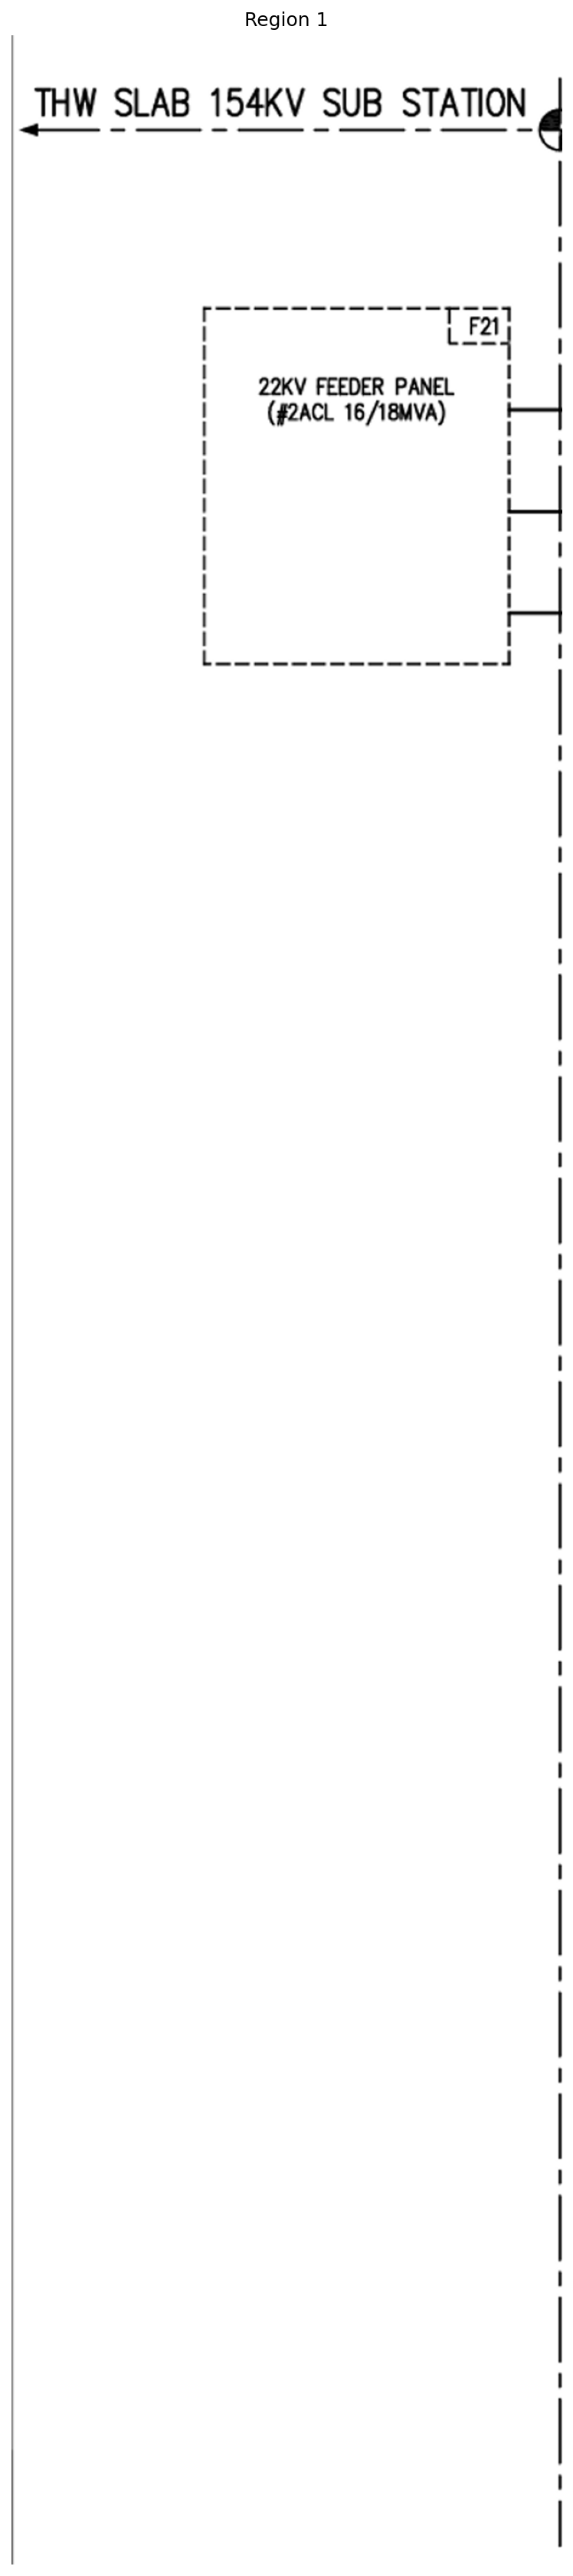

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_c

BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
THW SLAB 154KV SUB STATION

22KV FEEDER PANEL  
(#2ACL 16/18MVA)
image size:  (622, 2856)
valid image tokens:  555
output texts tokens (valid):  30
compression ratio:  0.05
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


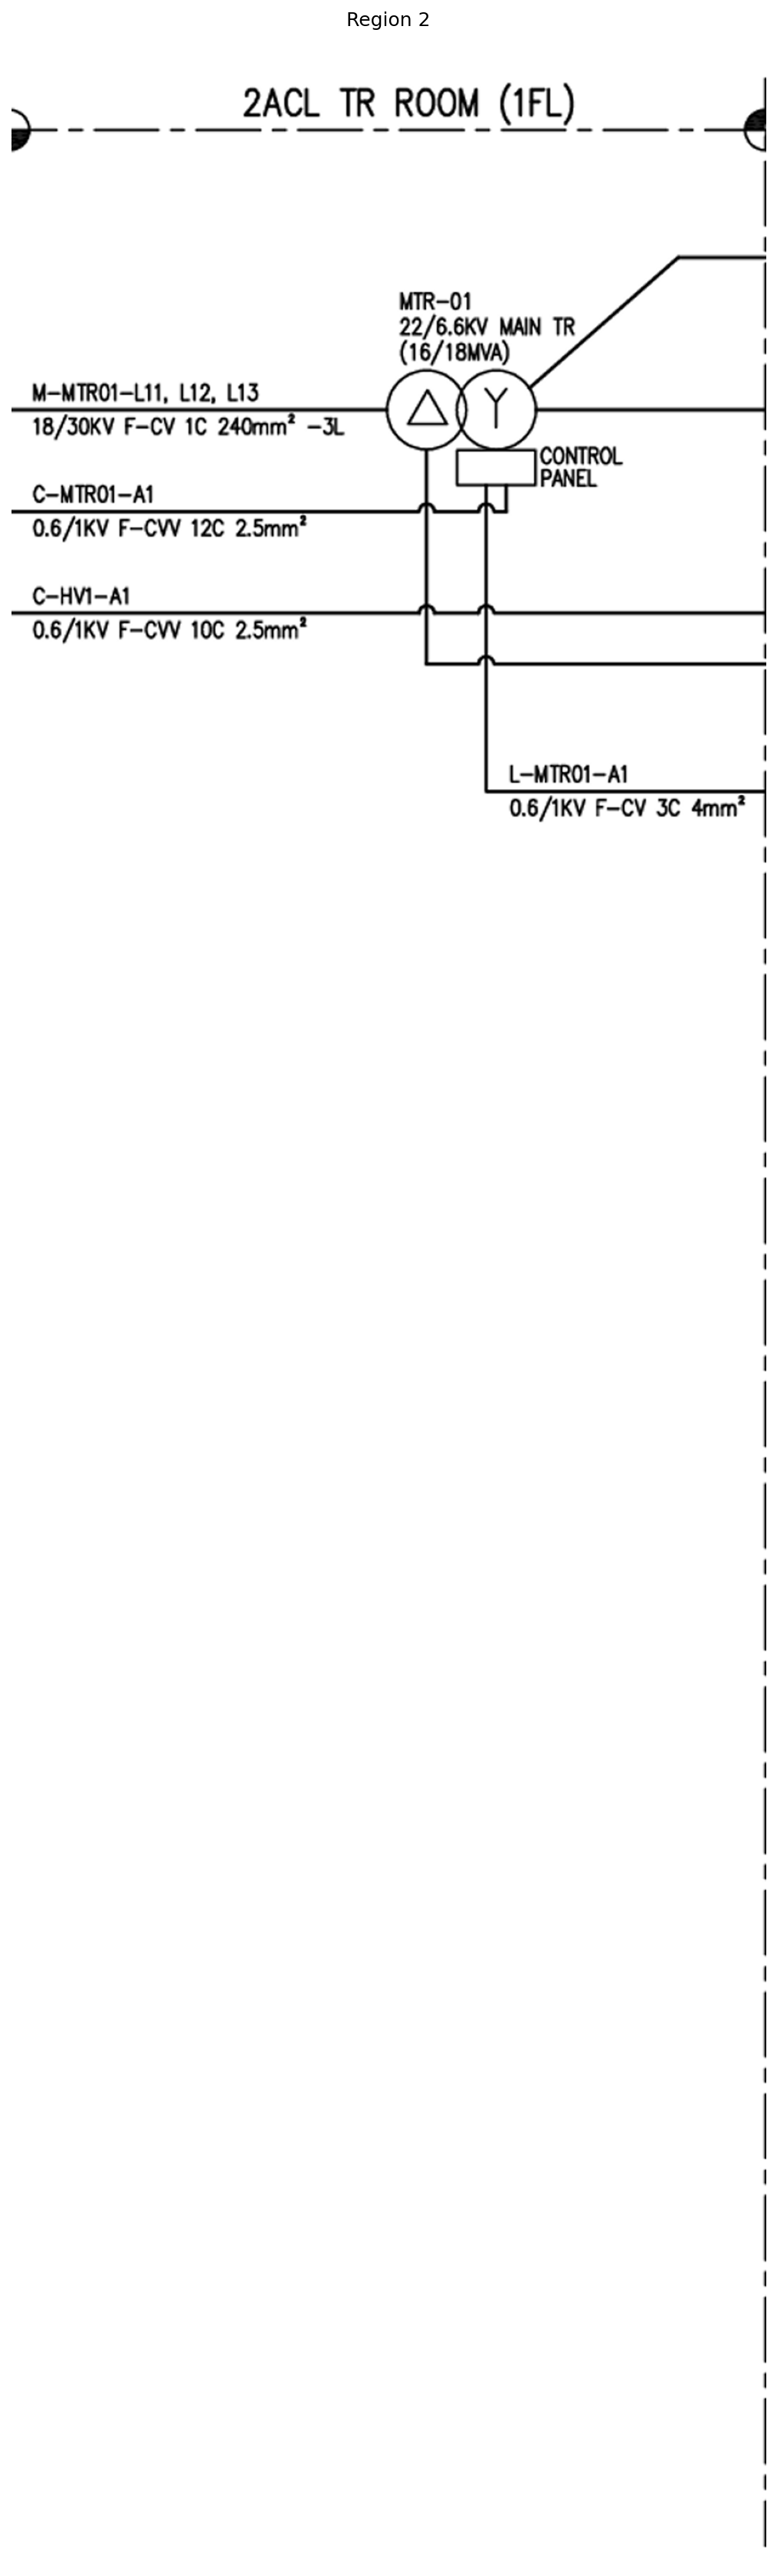

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
2ACL TR ROOM (1FL)

M-MTR01–L11, L12, L13  
18/30KV F–CV 1C 240mm² – 3L  

C–MTR01–A1  
0.6/1KV F–CVV 12C 2.5mm²  

C–HV1–A1  
0.6/1KV F–CVV 10C 2.5mm²  

MTR–01  
22/6.6KV MAIN TR  
(16/18MVA)  

CONTROL  
PANEL  

L–MTR01–A1  
0.6/1KV F–CV 3C 4mm²
image size:  (852, 2856)
valid image tokens:  376
output texts tokens (valid):  154
compression ratio:  0.41
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


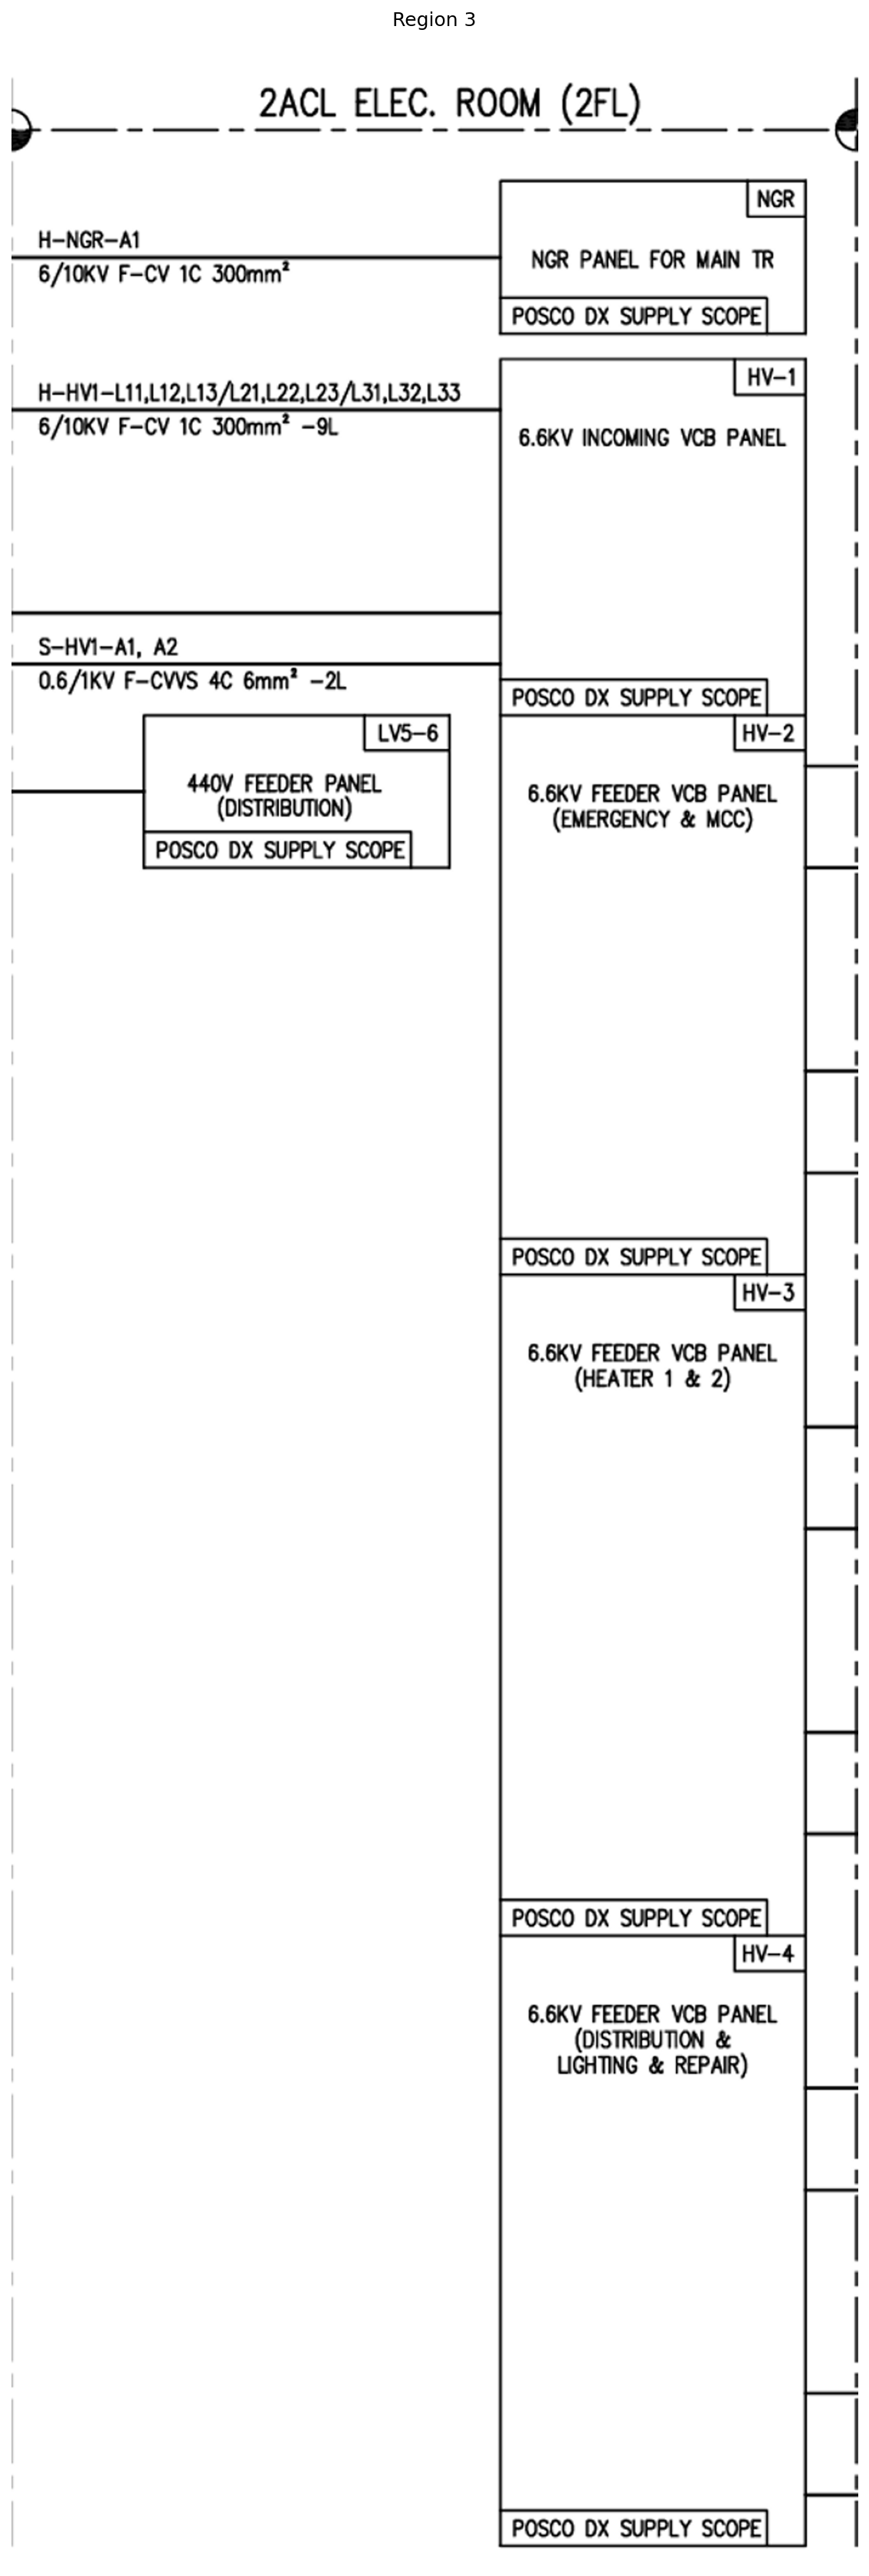

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
# 2ACL ELEC. ROOM (2FL)

---

## H-NGR-A1
6/10KV F-CV 1C 300mm²

---

## H-HV1-L11,L12,L13/L21,L22,L23/L31,L32,L33
6/10KV F-CV 1C 300mm² -9L

---

## S-HV1-A1, A2
0.6/1KV F-CVVS 4C 6mm² -2L

---

LV5-6

440V FEEDER PANEL (DISTRIBUTION)

POSCO DX SUPPLY SCOPE

---

## NGR
NGR PANEL FOR MAIN TR

POSCO DX SUPPLY SCOPE

---

## HV-1
6.6KV INCOMING VCB PANEL

---

## POSCO DX SUPPLY SCOPE
POSCO DX SUPPLY SCOPE

---

## HV-2
6.6KV FEEDER VCB PANEL (EMERGENCY & MCC)

---

## POSCO DX SUPPLY SCOPE
POSCO DX SUPPLY SCOPE
POSCO DX SUPPLY SCOPE

---

## POSCO DX SUPPLY SCOPE
POSCO DX SUPPLY SCOOPE

---

## HV-3
6.6KV FEEDER VCB PANEL (HEATER 1 & 2)

---

## POSCO DX SUPPLY SCOPE
POSCO DX SUPPLY SCOOPE
image size:  (956, 2856)
valid image tokens:  385
output texts tokens (valid):  317
compression ratio:  0.82
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


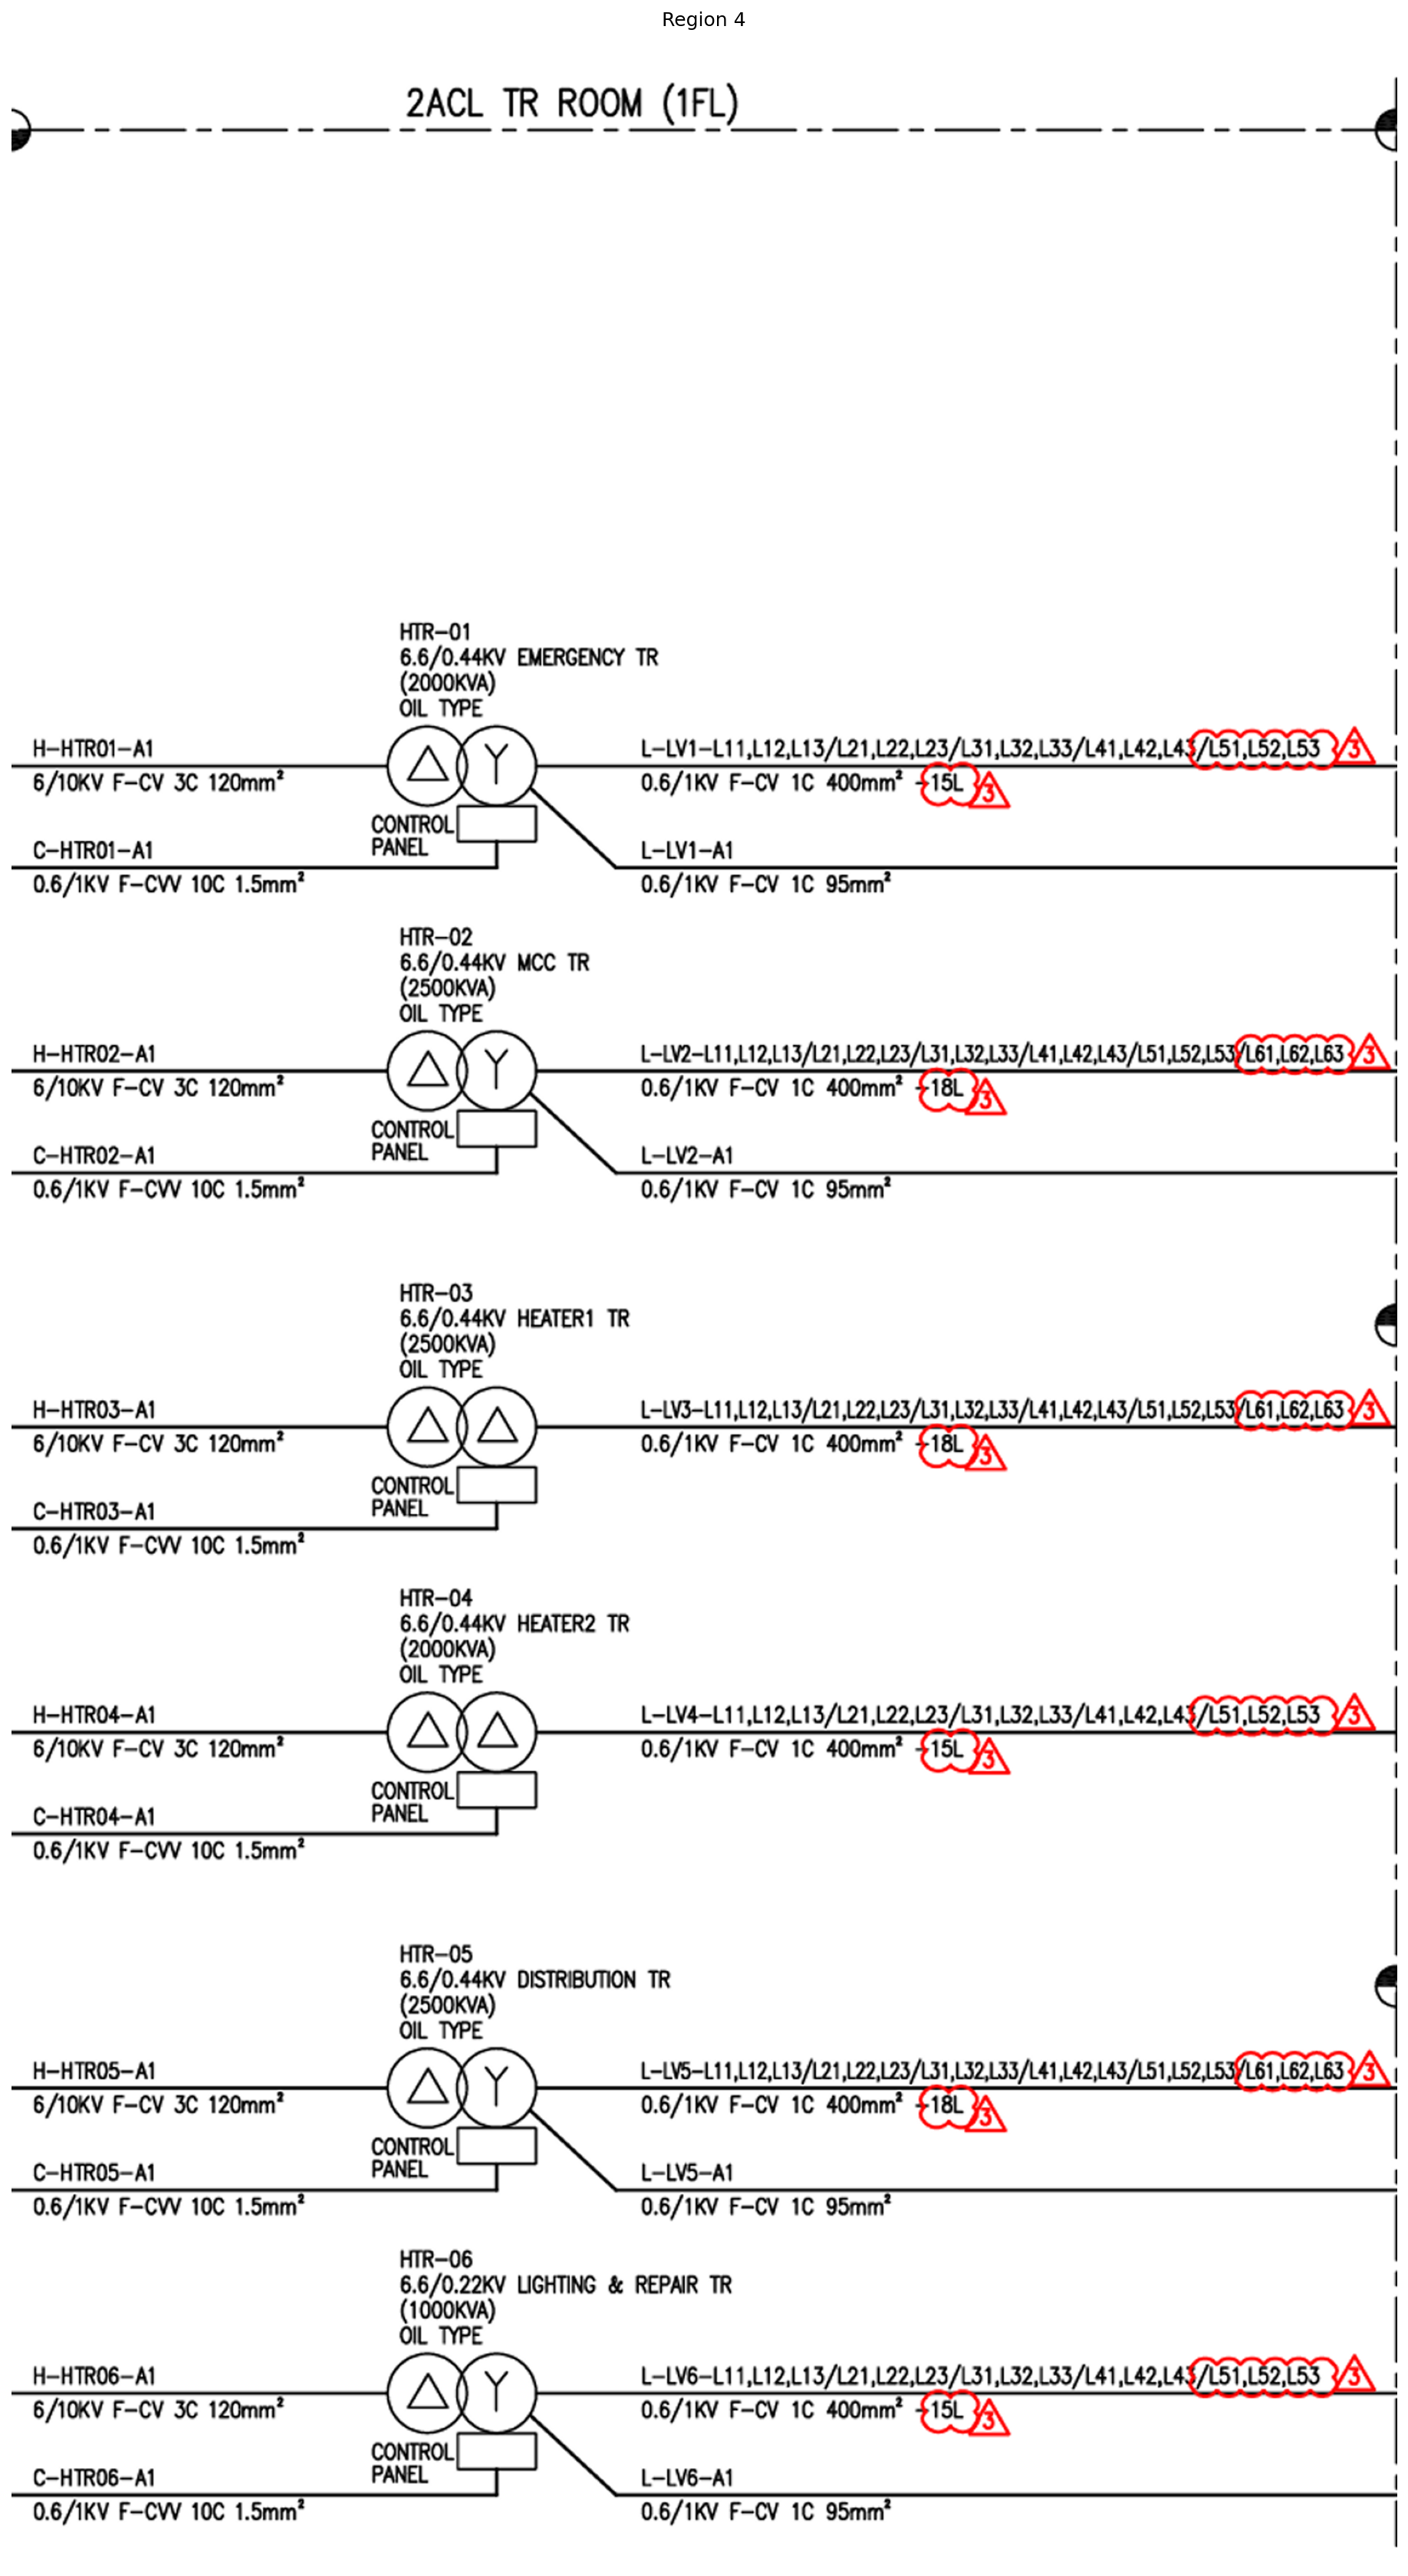

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
# 2ACL TR ROOM (1FL)

## HTR-01
6.6/0.44KV EMERGENCY TR  
(2000KVA)  
OIL TYPE  

H-HTR01-A1  
6/10KV F-CV 3C 120mm²  
C-HTR01-A1  
0.6/1KV F-CV 10C 1.5mm²  

L-LV1-L11,L12,L13/L21,L22,L23/L31,L32,L33/L41,L42,L43/L51,L52,L53  
0.6/1KV F-CV 1C 400mm²  
15L  

L-LV1-A1  
0.6/1KV F-CV 1C 95mm²  

---

## HTR-02
6.6/0.44KV MCC TR  
(2500KVA)  
OIL TYPE  

H-HTR02-A1  
6/10KV F-CV 3C 120mm²  
C-LTR02-A1  
0.6/1KV F-CV 10C 1.5cm²  

L-LV2-L11,L12,L13/L21,L22,L23/L31,L32,L33/L31,L32,L33/L41,L42,L43/L51,L52,L53  
L-LV2-A1  
0.6/1KV F-CV 1C 95mm²  
18L  

---

## HTR-03
6.6/0.44KV HEATER1 TR  
(2500KVA)  
OIL TYPE  

H-HTR03-A1  
6/10KV F-CV 3C 120mm²  
C-HT03-A1  
0.6/1KV F-CV 10C 1.5m²  

L-LV3-L11,L12,L13/L21,L22,L23/L31,L32,L33/L11,L32,L33/L41,L42,L43/L51,L52,L53  
0.5/1KV F-CV 1C 400mm²  
18L  

---

## HTR-04
6.6/0.44KV HEATER2 TR  
(2000KVA)  
OIL TYPE  

H-HTR04-A1  
6/10KV F-CV 3C 120mm²  
C-HT04-A1  
0.6/1KV F-CV 1

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


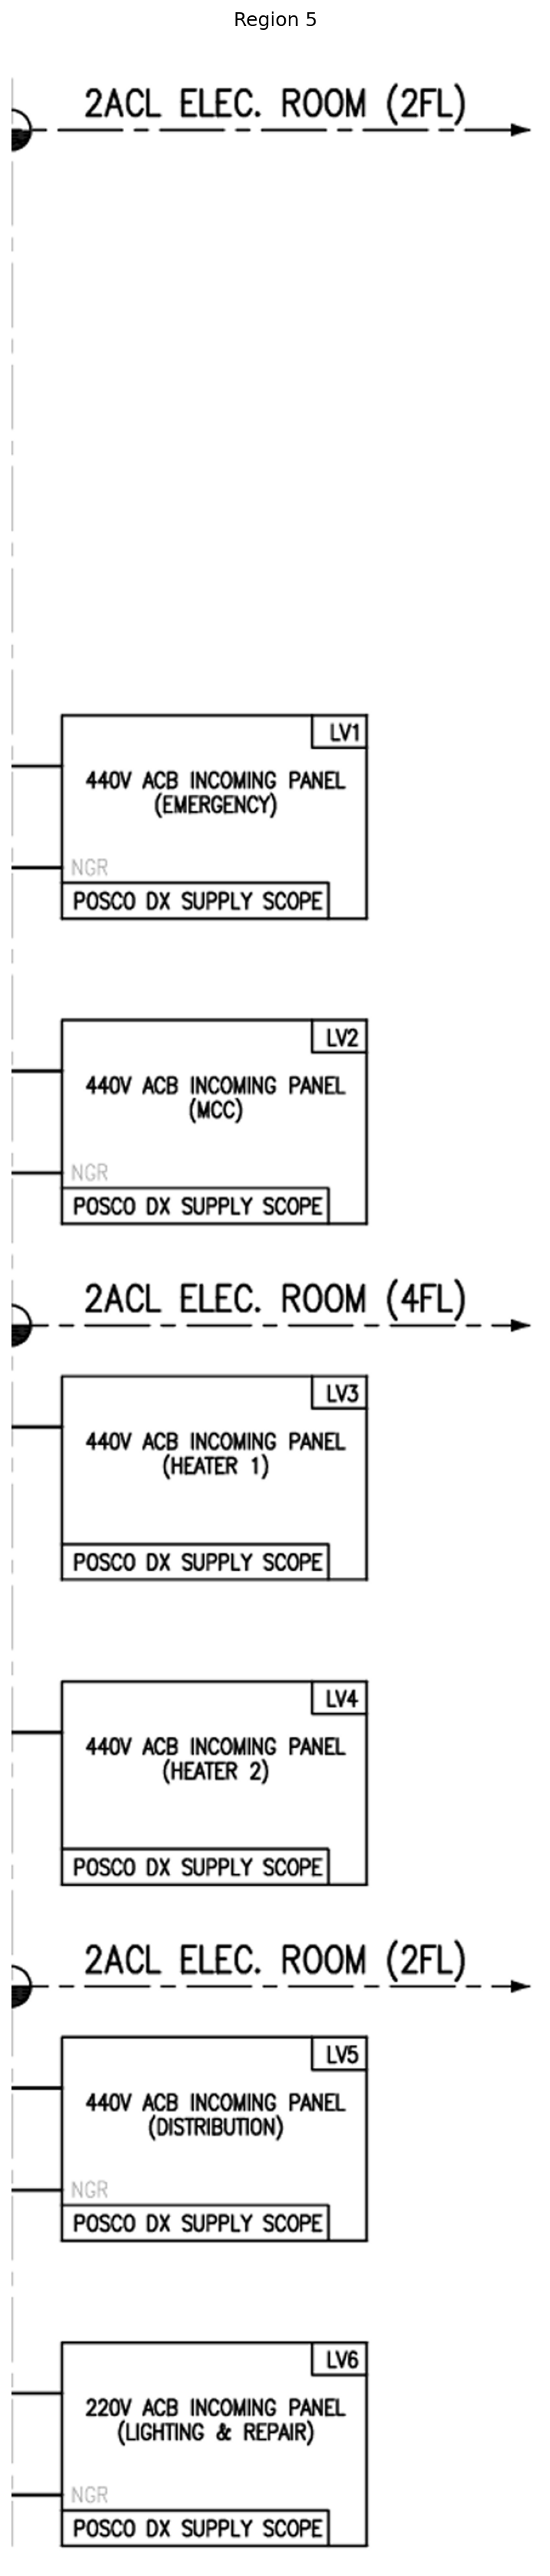

/home/dibaeck/anaconda3/envs/proj_v4/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
2ACL_ELEC. ROOM (2FL)

LV1
440V ACB INCOMING PANEL (EMERGENCY)
NGR
POSCO DX SUPPLY SCOPE

LV2
440V ACB INCOMING PANEL (MCC)
NGR
POSCO DX SUPPLY SCOPE

2ACL_ELEC. ROOM (4FL)

LV3
440V ACB INCOMING PANEL (HEATER 1)
NGR
POSCO DX SUPPLY SCOPE

LV4
440V ACB INCOMING PANEL (HEATER 2)
NGR
POSCO DX SUPPLY SCOPE

2ACL_ELEC_ ROOM (2FL)

LV5
440V ACB INCOMING PANEL (DISTRIBUTION)
NGR
POSCO DX SUPPLY SCOPE

LV6
220V ACB INCOMING PANEL (LIGHTING & REPAIR)
NGR
POSCO DX SUPPLY SCOPE
image size:  (596, 2856)
valid image tokens:  553
output texts tokens (valid):  218
compression ratio:  0.39
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


In [3]:
# ROI 저장 및 OCR 수행
ocr_results = {}


for region_id, roi in regions:
    # ROI 시각화
    show_image_highres(roi, f"Region {region_id}", zoom=1.0, dpi=150)

    # OCR 수행
    roi_folder = os.path.join(output_path, f'region_{region_id}')
    os.makedirs(roi_folder, exist_ok=True)
    roi_file = os.path.join(roi_folder, f'roi_{region_id}.png')
    cv2.imwrite(roi_file, roi)
    
    if not is_text_like_present(roi):
        print(f"[Skip] Region {region_id} is empty or no text detected.")
        continue
    
    # Tesseract OCR 실행
    text = pytesseract.image_to_string(roi, lang='kor+eng')  # 한글+영어
    text = text.strip()
    if not text :
        print(f"[Skip] Region {region_id} is empty or no text detected.")
        continue
    
    res = model.infer(
        tokenizer,
        prompt=prompt,
        image_file=roi_file,
        output_path=roi_folder,
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=True,
        test_compress=True
    )
    ocr_results[region_id] = res